In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
from models import my_cv
from models.models import *
from models.database import *

In [2]:
#データセットの作成
"""
for i in range(1,13):
    img_ori = cv2.imread('./sample_images/train/'+str(i)+'.png')#画像読み込み
    print(np.shape(img_ori))
    #my_cv.display_color(img_ori)
    #紙の部分を切り出す
    img_paper = my_cv.cutting_paper(img_ori)
    my_cv.display_color(img_paper,output_file_path = "./tmp/paper.png")
    paper = Paper(img_paper,"Sho","Mizu")
    score1s , score2s = paper.get_scores(True)
"""

'\nfor i in range(1,13):\n    img_ori = cv2.imread(\'./sample_images/train/\'+str(i)+\'.png\')#画像読み込み\n    print(np.shape(img_ori))\n    #my_cv.display_color(img_ori)\n    #紙の部分を切り出す\n    img_paper = my_cv.cutting_paper(img_ori)\n    my_cv.display_color(img_paper,output_file_path = "./tmp/paper.png")\n    paper = Paper(img_paper,"Sho","Mizu")\n    score1s , score2s = paper.get_scores(True)\n'

In [3]:
#labeling
"""
df = DB.get_df()
for i, row in df.iterrows():
    img = cv2.imread(row["img_char_path"])
    my_cv.display_color(img)
    img = cv2.imread(row["img_rec_path"],-1)
    my_cv.display_color(img)
    label  = input()
    df.loc[i,"label"] = int(label)
DB.save(df)
"""

'\ndf = DB.get_df()\nfor i, row in df.iterrows():\n    img = cv2.imread(row["img_char_path"])\n    my_cv.display_color(img)\n    img = cv2.imread(row["img_rec_path"],-1)\n    my_cv.display_color(img)\n    label  = input()\n    df.loc[i,"label"] = int(label)\nDB.save(df)\n'

In [22]:
#ラベルの抽出
df = DB.get_df()
Y = df["label"].values.astype(np.int32)# ラベル



In [23]:
X_arr = None #説明変数
X_arr = np.stack([cv2.imread(path,0) for path in df["img_rec_path"] ])
X_arr = X_arr.reshape((len(X_arr), 1, 20, 20)).astype(np.float32)

In [24]:
#分割
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_arr, Y, test_size=0.2, random_state=0) #分割
#型変換
X_train = X_train.astype(np.float32)
X_train /= 255
X_test = X_test.astype(np.float32)
X_test /= 255
print(X_train.shape)

(192, 1, 20, 20)


In [54]:
#CNN
from chainer import Sequential
import chainer.functions as F
import chainer.links as L
import chainer
from chainer import Chain, optimizers, Variable, serializers

class CNN(Chain):#出力数を受け取ってcnnを作成する
    def __init__(self):
        output_num = 2
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 32, 5), # filter 5
            conv2 = L.Convolution2D(32, 64, 5), # filter 5
            l1 = L.Linear(256, 200),
            l2 = L.Linear(200, 300),
            l3 = L.Linear(300, output_num, initialW=np.zeros((output_num, 300), dtype=np.float32))
        )
    def forward(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h


In [60]:
#学習
model = CNN()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
n_epoch = 1
batch_size = 192
for epoch in range(n_epoch):
    sum_loss = 0
    sum_accuracy = 0
    perm = np.random.permutation(len(X_train))
    for i in range(0, len(X_train), batch_size):
        x = Variable(X_train[perm[i:i+batch_size]])
        t = Variable(Y_train[perm[i:i+batch_size]])
        y = model.forward(x)
        model.zerograds()
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data*batch_size
        sum_accuracy += acc.data*batch_size
    #print("epoch: {}, mean loss: {}, mean accuracy: {}".format(epoch, sum_loss/len(X_train), sum_accuracy/len(X_train)))
    cnt = 0
    for i in range(len(X_test)):
        x = Variable(np.array([X_test[i]], dtype=np.float32))
        t = Y_test[i]
        y = model.forward(x)
        print(np.shape([X_test[i]]))
        print(y)
        y = np.argmax(y.data[0])
        if t == y:
            cnt += 1
    print("epoc"+str(epoch)+"\ttrain_accuracy:"+str(round(float(acc.data),4))+"\t\ttest_accuracy:"+str(round(cnt/len(X_test),4)))
#testに対する学習



(1, 1, 20, 20)
variable([[ 0.00265973 -0.00265973]])
(1, 1, 20, 20)
variable([[-0.00725581  0.00725581]])
(1, 1, 20, 20)
variable([[-0.00499082  0.00499082]])
(1, 1, 20, 20)
variable([[-0.00403379  0.00403379]])
(1, 1, 20, 20)
variable([[-0.00157267  0.00157267]])
(1, 1, 20, 20)
variable([[ 0.0020417 -0.0020417]])
(1, 1, 20, 20)
variable([[-0.00259139  0.00259139]])
(1, 1, 20, 20)
variable([[-0.00807682  0.00807682]])
(1, 1, 20, 20)
variable([[-0.00296923  0.00296923]])
(1, 1, 20, 20)
variable([[-0.00166883  0.00166883]])
(1, 1, 20, 20)
variable([[ 0.00177852 -0.00177852]])
(1, 1, 20, 20)
variable([[-0.0014885  0.0014885]])
(1, 1, 20, 20)
variable([[-0.00196501  0.00196501]])
(1, 1, 20, 20)
variable([[-0.00442696  0.00442696]])
(1, 1, 20, 20)
variable([[-0.01253208  0.01253208]])
(1, 1, 20, 20)
variable([[-0.00675865  0.00675865]])
(1, 1, 20, 20)
variable([[-0.00452384  0.00452384]])
(1, 1, 20, 20)
variable([[-0.00193043  0.00193043]])
(1, 1, 20, 20)
variable([[-0.00982347  0.00982347]

In [39]:
#chainer.serializers.save_npz('cnn.net', model)

In [104]:
from  .models.nn import Recognizer

ImportError: attempted relative import with no known parent package

In [75]:
df = DB.get_df()

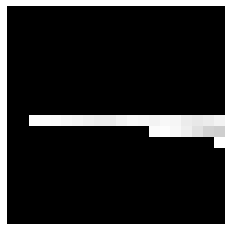

In [106]:
rec = cv2.imread(df.loc[df.index[1],"img_rec_path"],0)
my_cv.display_gray(rec)

In [107]:
class Recognizer():
    @staticmethod
    #rectangleを受け取ってlabelとconfidenceを返す
    def predict(rec):
        
        rec = rec.reshape((1,1,20,20)).astype(np.float32)
        rec /= 255
        x = Variable(np.array(rec, dtype=np.float32))
        model = CNN()
        chainer.serializers.load_npz("cnn.net",model)
        y = model.forward(x)
        label = np.argmax(y.data[0])
        confidence = abs(y.data[0][0])*100

        return label,confidence

In [108]:
Recognizer.predict(rec)

(0, array([1399.3947, 1399.4037], dtype=float32))